# Contributing to stdpopsim
In this workshop we are going to go through the major routes by which one can add to the `stdpopsim` catalog specifically, but to a lesser extent along the way we will highlight the myriad additions and contributions that we'd love to see the community build on to the project. 

By way of a road map, through this workshop we will look at 1) how to add a new species genome to the `stdpopsim` catalog, using the mosquito _Anopheles gambiae_ as our example, 2) adding a genetic map to our genome, and 3) adding a demographic model to our new species or any other that already exists in the catalog. 

## Getting ready to develop with us on github
[Github](https://github.com) provides an incredibly powerful tool for us to collaboratively build code on. Their platform enables everything from automated testing, to code review tools, to excellent version control. As we step through the workshop, at various turns we will depend on Github and its commandline engine `git`. 

### Create your own fork of stdpopsim
Okay the first step towards contributing to `stdpopsim` is to create your own _fork_ on github. Do to that
natigate to [the popsim-consortium github repo](https://github.com/popsim-consortium/stdpopsim) and hit the `fork` button on the top right (see Figure 1 below). 
![Figure 1. Fork our repo on Github](gh1.png)

### Clone your fork locally
Next clone your now up-to-date fork locally on to your machine. This can be done at the commandline using `git` as
```
git clone https://github.com/<your_username>/stdpopsim.git
```
with your actual github username in place of `<your_username>`.

### Setup a python environment to code in
Next (and for the sake of completeness) I'm going to start by setting up a new `conda` virtual environment and then will install the `stdpopsim` development requirements onto that using `pip`. Further documentation on installation of `stdposim` can be found [here](https://stdpopsim.readthedocs.io/en/latest/development.html#installation).
```
cd stdpopsim
conda create -n stdpopsim python=3.9 --yes
conda activate stdpopsim
pip install -r requirements/development.txt
```
with that done everything should be in place for us to start coding!

finally as a last step I will setup the automated code checking / error correction that we use by running 
```
pre-commit install
```

## Adding a species
For the sake of the workshop we are going to go through all of the steps that it would take to add a species, in this case _Anopheles gambiae_. Again our workflow actually starts with considerations of `git` and version control. Our first step will be to create a new _branch_ of `stdpopsim` using `git` which will effectively keep track of the new features we will be adding

```
git checkout -b mosquito
```
now any changes that I commit, will only be committed to the branch called `mosquito`. 

`stdpopsim` has a few utilities that play well with [Ensembl](https://ensembl.org/index.html), including one that we will use to create some code templates for us to buildout a new species. This utility lives on the "maintenance" side of `stdpopsim` which houses utilities that are not user facing. 

To add our species we will hand the `maintenance` command line interface an Ensembl species ID and it will go and pull down some essential information about the genome. A partial list of the genomes housed on Ensembl [can be found here](https://metazoa.ensembl.org/species.html)
```
python -m maintenance add-species Anopheles_gambiae
```
and it returns to me
```
2021-03-10 12:30:59,590 [3668] INFO     maint: Adding new species AnoGam for Ensembl ID anopheles_gambiae
2021-03-10 12:30:59,590 [3668] INFO     maint: Writing genome data for AnoGam anopheles_gambiae
2021-03-10 12:30:59,591 [3668] INFO     ensembl: making request to http://rest.ensembl.org/info/assembly/anopheles_gambiae?synonyms=1
2021-03-10 12:31:00,468 [3668] INFO     ensembl: making request to http://rest.ensembl.org/info/genomes/anopheles_gambiae
2021-03-10 12:31:02,846 [3668] INFO     maint: AnoGam: name=Anopheles gambiae, common_name=Anopheles gambiae
2021-03-10 12:31:02,846 [3668] INFO     maint: Writing species definition stub to stdpopsim/catalog/AnoGam/species.py
2021-03-10 12:31:02,904 [3668] INFO     maint: Writing species test stub to tests/test_AnoGam.py
2021-03-10 12:31:02,938 [3668] INFO     ensembl: making request to http://rest.ensembl.org/info/data
2021-03-10 12:31:03,853 [3668] INFO     maint: Using Ensembl release 103
```
wicked. The next steps are going to be to flesh out the code templates that the `maintenance` code just wrote for us in our branch. Let's go look at the files that were just created for us and we will compare them to a closely related genome. 

### Looking at the catalog

The function call above has created a few new files in the directory structure of stdpopsim, in particular at the level of `stdpopsim/catalog` this utility has created a new directory called `AnoGam`, which contains three files. The 3 + 3 naming scheme for this directory (and all following references in `stdpopsim`) is automatically parsed by the maintenance script.
```
├── catalog
│   ├── AnoGam
│   │   ├── __init__.py
│   │   ├── genome_data.py
│   │   └── species.py
```



first lets look in `genome_data.py` file. this contains the **physical map** of the genome. 

In [9]:
! cat ../../stdpopsim/stdpopsim/catalog/AnoGam/genome_data.py

# File autogenerated from Ensembl REST API. Do not edit.
data = {
    "assembly_accession": "GCA_000005575.1",
    "assembly_name": "AgamP4",
    "chromosomes": {
        "2L": {"length": 49364325, "synonyms": []},
        "2R": {"length": 61545105, "synonyms": []},
        "3L": {"length": 41963435, "synonyms": []},
        "3R": {"length": 53200684, "synonyms": []},
        "X": {"length": 24393108, "synonyms": []},
        "Mt": {"length": 15363, "synonyms": []},
    },
}


so we can see that the utility we can, has sucked down a whole lot of useful information for us for free. this `genome_data.py` essentially puts together a data dictionary which has slots for the assembly accession number, the assembly name, and a dict representing the chromosome names and their associated lengths. If synonymns are defined (e.g., chr2L for 2L) then those are given in the list that follows. There is no reason to edit this file-- we are good here. 

Next let's look at the `species.py` file. This is the file that we will need to edit with our species specific information. The basics that we will need here include:
- a genome-wide average recombination rate
- a genome-wide average mutation rate
- a generate time estimate (in years)
- a default population size
- literature citations that one can point to for the above and the assembly

in addition there is some optional information that we might add. this could include chromosome specific recombination
or mutation rates, but we will keep things simple for the most part today.

### recombination rates
As a reference for recombination rates in my organism I'm going to use a mapping based study from [Pombi et al. (2006)](https://doi.org/10.4269/ajtmh.2006.75.901).
In that manuscript the authors cite rates around 1cM/Mb, with a bit of variation among arms. In particular let's edit the following block of code in `species.py` that defines the recombination_rate dict

In [ ]:
_recombination_rate = {
    "2L": 0, #setting to zero because of inversion 
    "2R": 1.3e-8, 
    "3L": 1.6e-8, 
    "3R": 1.3e-8, 
    "X": 1e-8,
    "Mt": 0
}

next we need to add a citation for these rates. will we do that by adding a `stdpopsim.Citation` object to the file that we will include later. that Citation object looks like this

In [ ]:
_PombiEtAl = stdpopsim.Citation(
    doi="https://doi.org/10.4269/ajtmh.2006.75.901",
    year=2006,
    author="Pombi et al.",
    reasons={stdpopsim.CiteReason.REC_RATE},
)

okay having edited our file that takes care of recombination rate defaults and citations. Next we need to add mutation rates. As it turns out we don't have great estimates for mutation rate in Anopheles but in a recent population genomics effort by the [Ag1000G consortium](https://doi.org/10.1038/nature24995) we have relied on Drosophila estimates from [Schrider et al. (2013)](https://doi.org/10.1534/genetics.113.151670) that set $u=5.49e^{-9}$. We'll go with that. 

So again first let's add a citation for the mutation rate and then edit the `_mutation_rate` dict that was templated for us

In [ ]:
_Ag1000G = stdpopsim.Citation(
    doi="https://doi.org/10.1038/nature24995",
    year=2017,
    author="Ag1000G Consortium",
    reasons={stdpopsim.CiteReason.MUT_RATE, stdpopsim.CiteReason.GEN_TIME, stdpopsim.CiteReason.POP_SIZE},
)

and for the mutation rate block let's set an overall rate as suggested and then populate our dict

In [ ]:
_overall_rate = 5.49e-9
_mutation_rate = {
    "2L": _overall_rate,
    "2R": _overall_rate,
    "3L": _overall_rate,
    "3R": _overall_rate,
    "X": _overall_rate,
    "Mt": _overall_rate
}

I still need an assembly citation. Ensembl points me to this publication for
their current assembly by [Sharakhova et al. (2006)](https://doi.org/10.1186/gb-2007-8-1-r5). I'll create a citation for that and then edit

In [ ]:
_SharakhovaEtAl = stdpopsim.Citation(
    doi="https://doi.org/10.1186/gb-2007-8-1-r5",
    year=2006,
    author="Sharakhova et al.",
    reasons={stdpopsim.CiteReason.ASSEMBLY},
)

and now we will put it all together to create the genome object

In [ ]:
_genome = stdpopsim.Genome.from_data(
    genome_data.data,
    recombination_rate=_recombination_rate,
    mutation_rate=_mutation_rate,
    citations=[
        _SharakhovaEtAl,
        _Ag1000G,
        _PombiEtAl,
    ],
)

Finally I'm going to edit the species definition in `species.py` to include a default population size and generation time. 

For this we will again rely on the Ag1000G paper and call the generation time 11 gens per year and the population size approximately 6 million, which corresponds to the Ghana population sample

In [ ]:
_species = stdpopsim.Species(
    id="AnoGam",
    ensembl_id="anopheles_gambiae",
    name="Anopheles gambiae",
    common_name="Anopheles gambiae",
    genome=_genome,
    generation_time=1/11,
    population_size=6e6, #Ghana population
    citations=[_Ag100g]
)

now we can make sure this works at the command line
```
python -m stdpopsim AnoGam --help
```
returns for me
```
usage: __main__.py AnoGam [-h] [--help-models [HELP_MODELS]] [-b BIBTEX_FILE] [-D] [-c] [-L LENGTH] [-i INCLUSION_MASK]
                          [-e EXCLUSION_MASK] [-l LENGTH_MULTIPLIER] [-s SEED] [-d] [-o OUTPUT]
                          samples [samples ...]

Run simulations for Anopheles gambiae using up-to-date genome
information, genetic maps and simulation models from the literature.
NOTE: By default, the tskit '.trees' binary file is written to
stdout,so you should either redirect this to a file or use the '--
output' option to specify a filename.

Default population parameters for Anopheles gambiae:
Generation time: 0.09090909090909091
Population size: 6000000.0
Mutation rate: 5.49e-09
Recombination rate: 1.044e-08

...
...
...
```

so we are looking good and everything is working! next up-- adding tests

## Adding tests
`stdpopsim` in part guarantees code quality through the use of unit testing. We will add some basic tests for our new species over the `tests/test_AnoGam.py` file our `add-species` utility stubbed out for us.

Tests at the level of individual species are meant to be idiosyncratic, so our example need not be laborious.



### Initiating a Pull Request for your species
Okay if we are happy enough with our species we are ready to commit all our changes to our branch and start a pull request on github. First we double check we are on our new branch
```
git branch -v
```
and if all good we are ready to commit with
```
git commit -am "added mosquito genome woot"
```




Part of starting the pull request will be initializing a new issue using the Species QC template seen below
![Figure 2](gh2.png)

# add a demographic history
As part of the Ag1000G paper we estimated population size histories from each population 
using the stairwayplot method. I'm going to download one of these estimated histories here and manipulate the file a bit to pull out the times and population sizes going back in time.

First download the history.

In [18]:
!wget ftp://ngs.sanger.ac.uk/production/ag1000g/phase1/AR3.1/stairway_plot/GAS.meru_mela.sfs.sp.summary 

--2021-03-10 16:05:57--  ftp://ngs.sanger.ac.uk/production/ag1000g/phase1/AR3.1/stairway_plot/GAS.meru_mela.sfs.sp.summary
           => ‘GAS.meru_mela.sfs.sp.summary’
Resolving ngs.sanger.ac.uk (ngs.sanger.ac.uk)... 193.62.203.79
Connecting to ngs.sanger.ac.uk (ngs.sanger.ac.uk)|193.62.203.79|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /production/ag1000g/phase1/AR3.1/stairway_plot ... done.
==> SIZE GAS.meru_mela.sfs.sp.summary ... 47711
==> PASV ... done.    ==> RETR GAS.meru_mela.sfs.sp.summary ... done.
Length: 47711 (47K) (unauthoritative)

GAS.meru_mela.sfs.s 100%[===================>]  46.59K  93.2KB/s    in 0.5s    

2021-03-10 16:06:03 (93.2 KB/s) - ‘GAS.meru_mela.sfs.sp.summary’ saved [47711]



then i'm going to chop out what i want using a little python. this code is a bit ugly
because of the file format, but I'm just trying to pull out a set of times and a set of population sizes that correspond to those times

In [52]:
def process_sp(fn, gen_time):
    """
    returns 2 x times array of 
    times and Ns
    """
    times = []
    ns = []
    f = open(fn,"r")
    seen = {}
    readingSp = False
    for line in f:
        line = line.strip().split()
        if line[0] == "mutation_per_site":
            readingSp = True
            first = True
        elif readingSp:
            mutPerSite, i, thetaPerSite, thetaPerSiteLow, thetaPerSiteHigh, year, neMedian, neLow, neHigh = line
            if not i in seen:
                year, neMedian, thetaPerSite = float(year), float(neMedian), float(thetaPerSite)
                assert not "." in i
                i = int(i)
                seen[i] = 1
                if first:
                    first = False
                    ne0 = neMedian
                    times.append(0)
                    ns.append(ne0)
                else:
                    times.append(year * gen_time)
                    ns.append(neMedian)
    return(np.array([np.array(times),np.array(ns)]))



Text(0, 0.5, 'N')

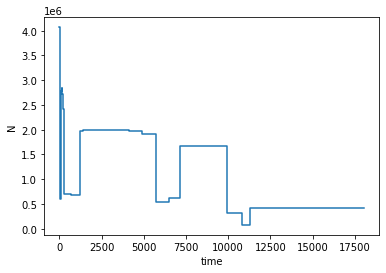

In [54]:
from matplotlib import pyplot as plt

x = process_sp("GAS.meru_mela.sfs.sp.summary",1/11)
plt.plot(x[0],x[1])
plt.xlabel("time")
plt.ylabel("N")